In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import os.path as osp
from typing import List, Union, Tuple
from dataclasses import dataclass, field

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
@dataclass
class LocalInstabilityResults:
    l1_distance: List[List[float]] = field(default_factory=list)
    ssim: List[List[float]] = field(default_factory=list)
    validity: List[float] = field(default_factory=list)
    

class ResultsParser:
    l1_distance_fname = 'li_l1.pkl'
    validity_fname = 'validity.pkl'
    ssim_fname = 'ssim.pkl'

    def __init__(self, 
                 method: str,
                 dataset_name: str = 'mnist',
                 target_class: str = '7', 
                 results_dir: str = '', 
                ):
        self.method = method
        self.ds_name = dataset_name
        self.target_class = target_class
        # TODO: raise error if results_dir is not set
        self.results_dir = results_dir

    def _parse_pickled_result(self, file_path):
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
        return results
    
    def parse_li_results(self, setting: str = 'binary') -> LocalInstabilityResults:
        file_map = {
            'l1_distance': ResultsParser.l1_distance_fname,
            'ssim': ResultsParser.ssim_fname,
            'validity': ResultsParser.validity_fname,
        }

        parsed = {}
        method_folder = f'{self.method}_{setting}'

        for key, fname in file_map.items():
            file_name = f'{self.ds_name}_{self.target_class}_{fname}'
            file_path = osp.join(self.results_dir, method_folder, file_name)
            parsed[key] = self._parse_pickled_result(file_path)

        return LocalInstabilityResults(**parsed)


In [37]:
class Plotter:
    sns.set_style("darkgrid")
    color_palette = sns.color_palette('deep')

    def __init__(self, 
                 bin_results: LocalInstabilityResults, 
                 multi_results: LocalInstabilityResults, 
                 noise_magnitudes: List[float] = None):
        self.bin_results = bin_results
        self.multi_results = multi_results
        self.noise_level_ticks = [f'$\\epsilon$={noise}' for noise in noise_magnitudes]

    def _combine_bin_and_multi(self, 
                               bin_array: np.ndarray, 
                               multi_array: np.ndarray) -> pd.DataFrame:
        # Combine binary and multi results into a DataFrame
        bin_df = self._convert2df(bin_array).T
        multi_df = self._convert2df(multi_array).T

        concat_df = pd.concat([bin_df, multi_df], axis=1, keys=['binary', 'multi'])
        # Convert columns to rows and adds to exta columns (level 0 (old index) and level 1 (key))  
        df_long = concat_df.stack(level=0, future_stack=True).reset_index()
        # Rename those added columns to "Index" and "Subgroup"
        df_long.columns = ['Index', 'Subgroup', *self.noise_level_ticks]

        df_melted = pd.melt(
            df_long,
            id_vars=['Index', 'Subgroup'],  # Columns to keep as identifiers
            value_vars=self.noise_level_ticks,  # Columns to melt
            var_name='Epsilon',  # Name for the melted variable column
            value_name='Value'  # Name for the melted value column
        )

        return df_melted
    
    def _convert2df(self, input: Union[List[float], np.ndarray]) -> pd.DataFrame:
        # Convert a 2D numpy array to a DataFrame
        return pd.DataFrame(input, index=self.noise_level_ticks)
    
    def plot_li_results(self, 
                        save_path: str = None,
                        title: str = '',
                        figsize: Tuple[int, int] = (12, 8),
                        val_text_padding: Tuple[int, int] = (-0.02, 0.02)):
        
        # Convert results to DataFrame
        bin_validity = self.bin_results.validity
        multi_validity = self.multi_results.validity

    
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
        val_ax = axs[0]
        li_ax = axs[1]
        ssim_ax = axs[2]
       
        # Plot validity in the first subplot 
        sns.lineplot(data=bin_validity, markers=True, palette=[Plotter.color_palette[0]], ax=val_ax)
        sns.lineplot(data=multi_validity, markers=True, palette=[Plotter.color_palette[1]], ax=val_ax)
        
        # Add validity values as text 
        for i, val in enumerate(bin_validity):
            val_ax.text(i, val+val_text_padding[0], f'{val:.0%}', c=Plotter.color_palette[0])

        for i, val in enumerate(multi_validity):
            val_ax.text(i, val+val_text_padding[1], f'{val:.0%}', c=Plotter.color_palette[1])

        
        val_ax.set_ylim([min(min(bin_validity), min(multi_validity))-0.1, 1+0.05])
        y_ticks = val_ax.yaxis.get_major_ticks()
        y_ticks[0].label1.set_visible(False)
        val_ax.set_ylabel('Validity')

        # Plot l1 distances of binary and multiclass experiments
        l1_df = self._combine_bin_and_multi(self.bin_results.l1_distance, self.multi_results.l1_distance)
        sns.boxplot(data=l1_df, hue='Subgroup', x='Epsilon', y='Value', palette=Plotter.color_palette, 
                    width=0.7, showmeans=True, fliersize=5, ax=li_ax)
        sns.set_context("paper", font_scale=2.5, rc={'font.size':24}) 
        li_ax.set_xlabel('')
        li_ax.set_ylabel('Local Instability \n(L1 distance)')
        li_ax.get_legend().remove()

        # Plot SSIM for binary and multiclass experiments
        ssim_df = self._combine_bin_and_multi(self.bin_results.ssim, self.multi_results.ssim)

        sns.boxplot(data=ssim_df, hue='Subgroup', x='Epsilon', y='Value', palette=Plotter.color_palette, 
                    width=0.7, showmeans=True, fliersize=5, ax=ssim_ax)
        ssim_ax.set_ylabel('Local instability \n(SSIM)')
        ssim_ax.set_ylim([0, 1.1])
        ssim_ax.set_xlabel('')
        ssim_ax.legend(title='', loc='best')

        fig.supxlabel('Noise magnitude')
        plt.suptitle(title)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1)

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f'Saved plot to {save_path}')

        plt.show()
    
    """def plot_ssim_results(self, save_path: str = None): 
        
        fig, axs = plt.subplots(figsize=(10, 6))
        ssim_df = self._combine_bin_and_multi(self.bin_results.ssim, self.multi_results.ssim)

        sns.boxplot(data=ssim_df, hue='Subgroup', x='Epsilon', y='Value', palette=Plotter.color_palette, 
                    width=0.7, showmeans=True, fliersize=5, ax=axs)
        axs.set_ylabel('Local instability (SSIM)')
        axs.set_ylim([0, 1.1])
        axs.set_xlabel('Noise magnitude')
        axs.legend(title="", loc='best')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f'Saved plot to {save_path}')

        plt.show()"""
    


# Comparing robustness of CFE algorithms in binary and multiclass settings

In [5]:
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]

### Local Instability: C3LT/MNIST

In [20]:
method = 'c3lt'
ds_name = 'mnist'
target_class = '7'
root_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/mnist'
# 'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\mnist'

In [21]:
parser = ResultsParser(method=method, dataset_name=ds_name, target_class=target_class, results_dir=root_dir)
li_bin = parser.parse_li_results(setting='binary')
li_multi = parser.parse_li_results(setting='multi')

In [40]:
plotter = Plotter(li_bin, li_multi, noise_magnitudes=noise_levels)

Saved plot to /data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/mnist/c3lt_7_li_l1_new.png


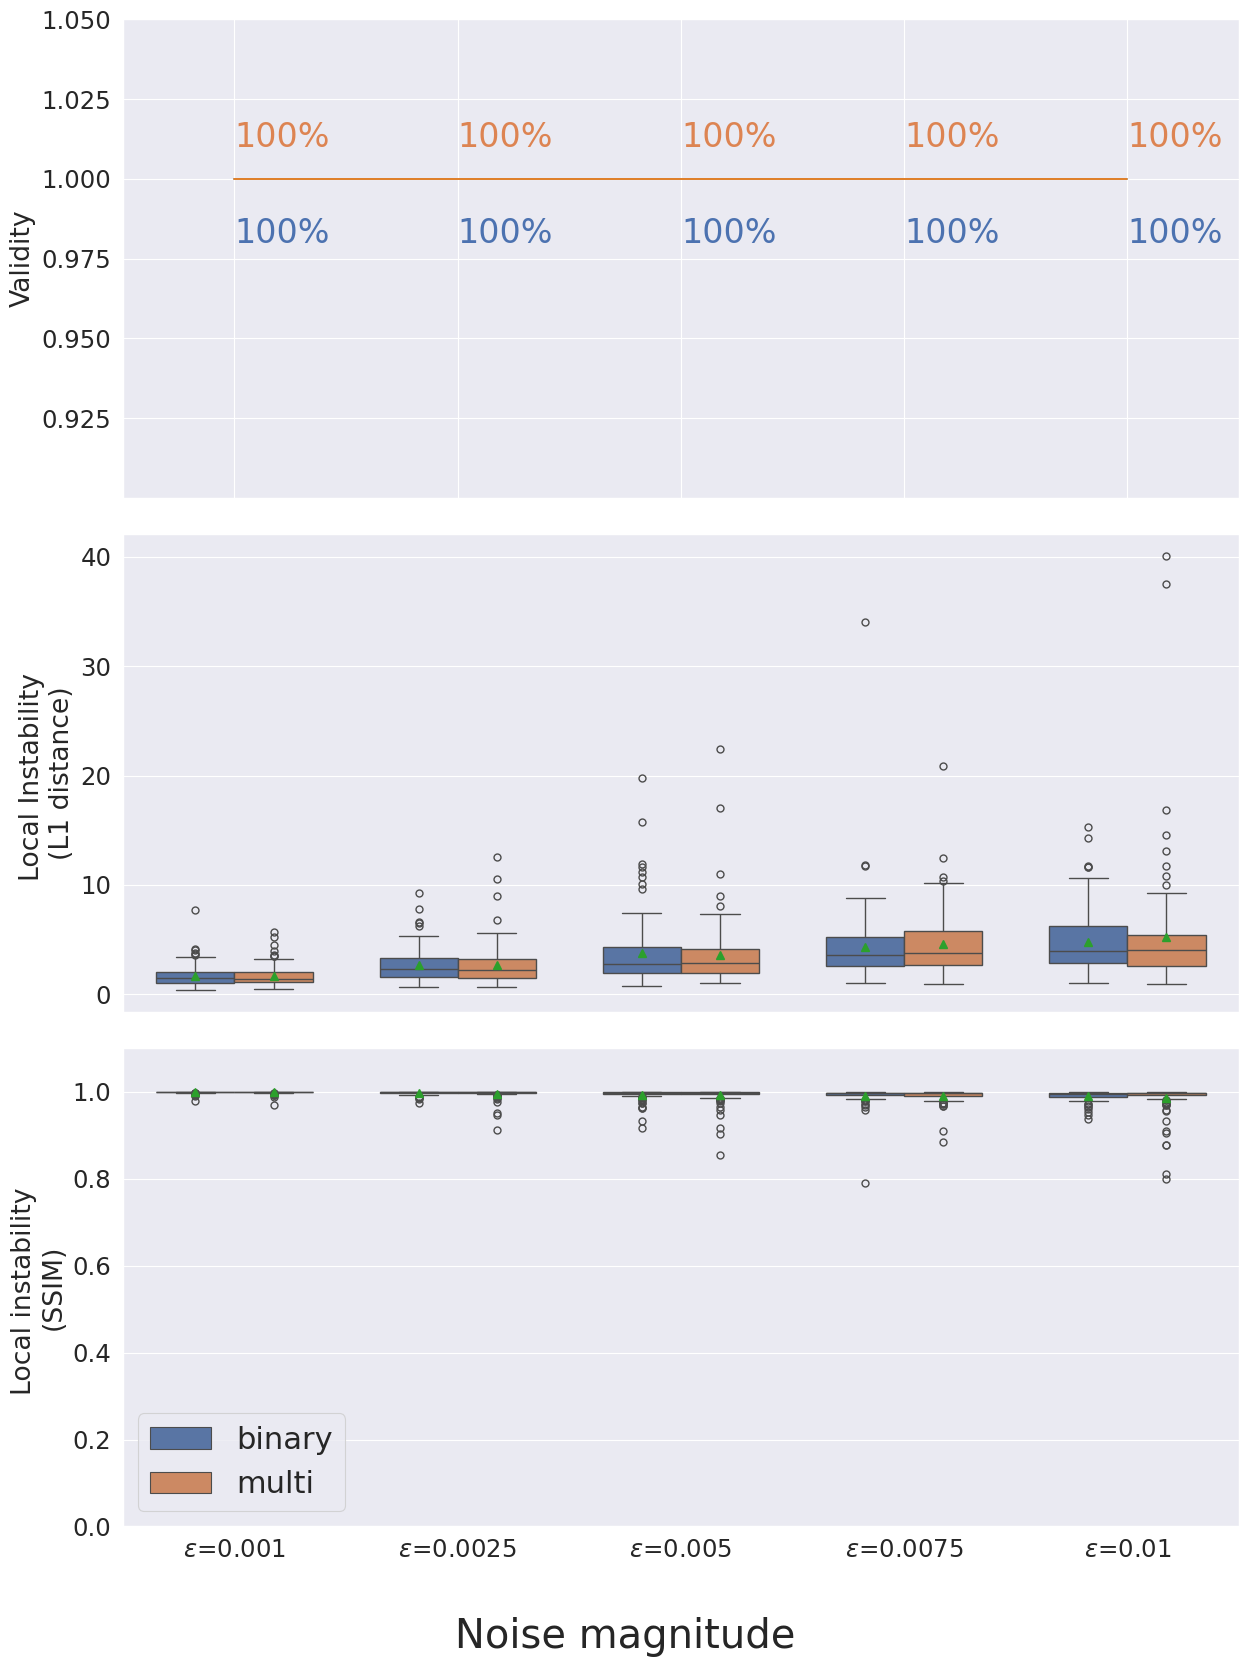

In [41]:
plotter.plot_li_results(save_path=osp.join(root_dir, 'c3lt_7_li_l1_new.png'), figsize=(13, 17))

### REVISE/MNIST

In [42]:
method = 'revise'
ds_name = 'mnist'
target_class = '7'
root_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/mnist'
# 'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\mnist'

In [45]:
parser = ResultsParser(method=method, dataset_name=ds_name, target_class=target_class, results_dir=root_dir)
li_bin = parser.parse_li_results(setting='binary')
# li_multi = parser.parse_li_results(setting='multi')

In [46]:
plotter = Plotter(li_bin, li_bin, noise_magnitudes=noise_levels)

Saved plot to /data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/mnist/revise_7_li_l1_new.png


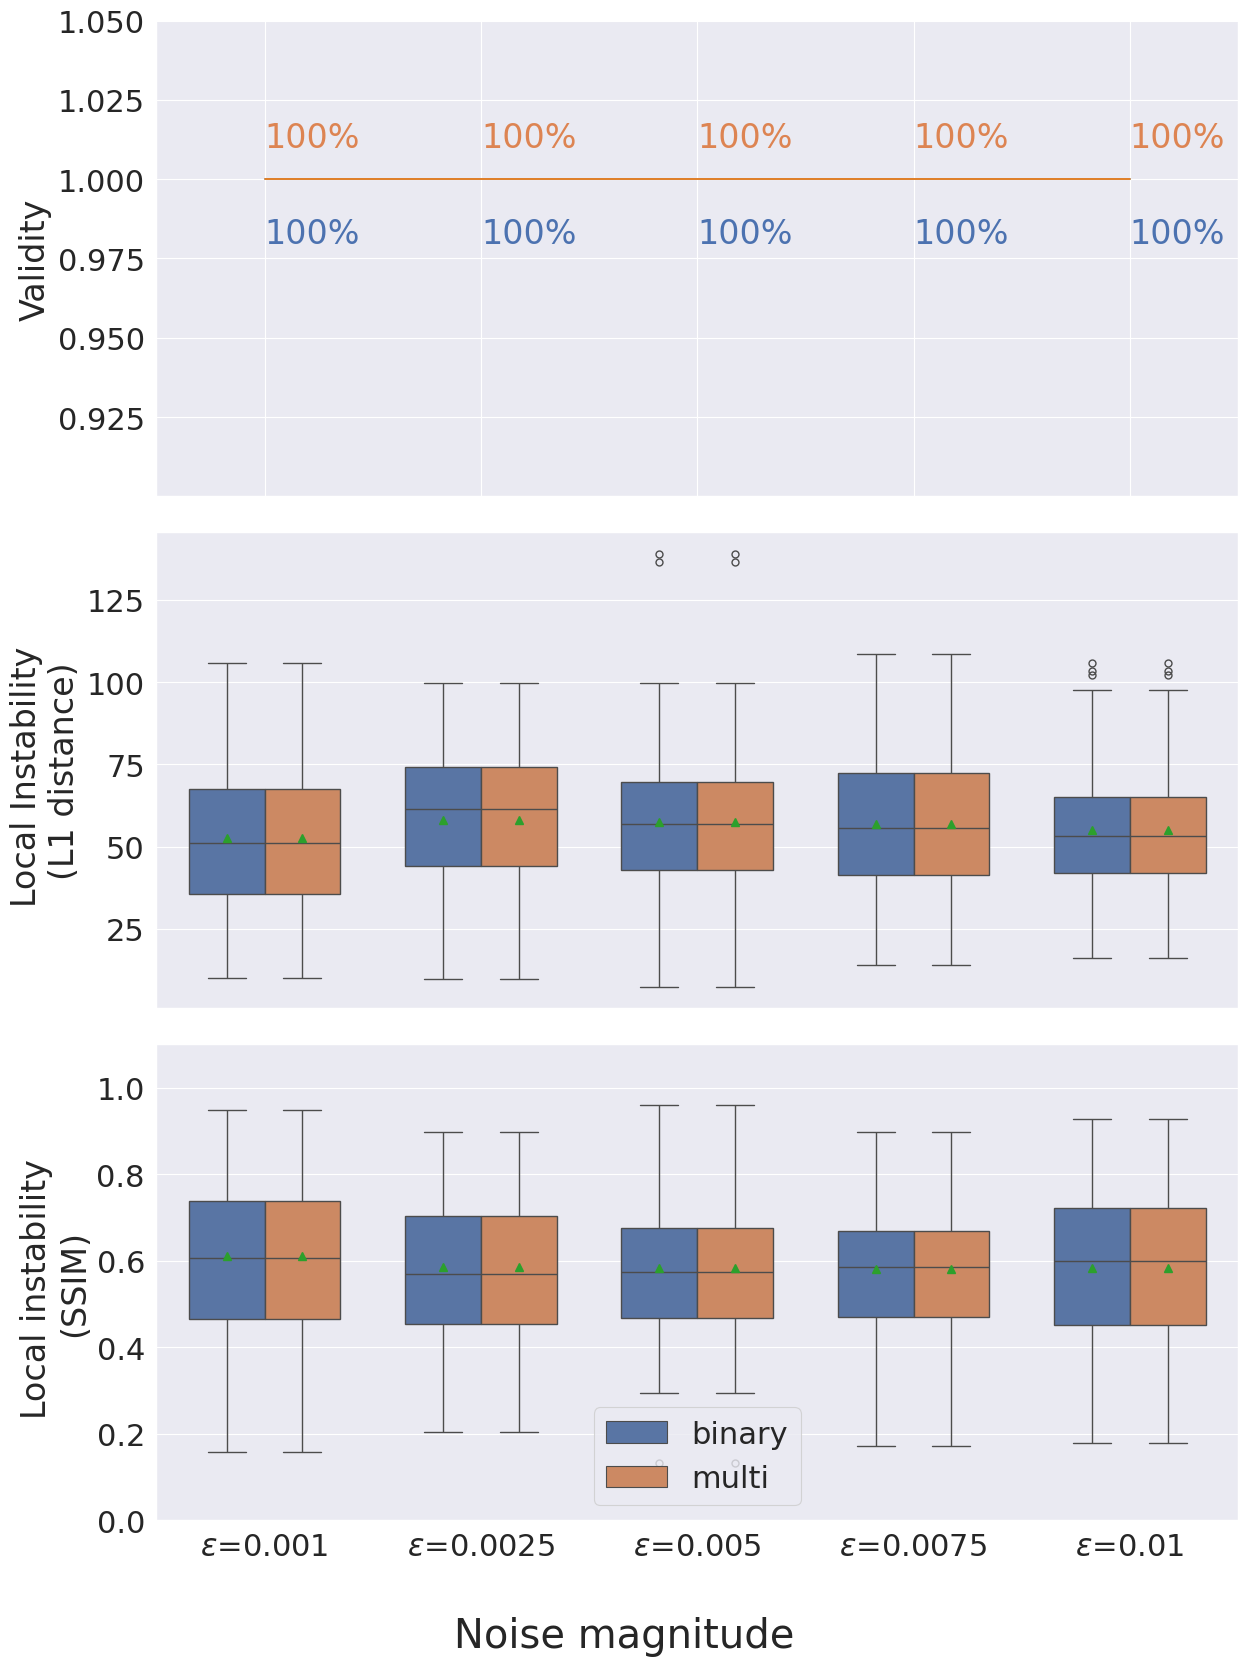

In [47]:
plotter.plot_li_results(save_path=osp.join(root_dir,  'revise_7_li_l1_new.png'), figsize=(13, 17))

In [ ]:
# plotter.plot_ssim_results(save_path=osp.join(root_dir, 'revise_7_li_ssim.png'))

### Local Instability: C3LT/FashionMNIST

In [7]:
method = 'c3lt'
ds_name = 'fmnist'
target_class = '4'
root_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist'
# 'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\mnist'

In [8]:
parser = ResultsParser(method=method, dataset_name=ds_name, target_class=target_class, results_dir=root_dir)
li_bin = parser.parse_li_results(setting='binary')
li_multi = parser.parse_li_results(setting='multi')

In [13]:
plotter = Plotter(li_bin, li_multi, noise_magnitudes=noise_levels)

Saved plot to /data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_4_li.png


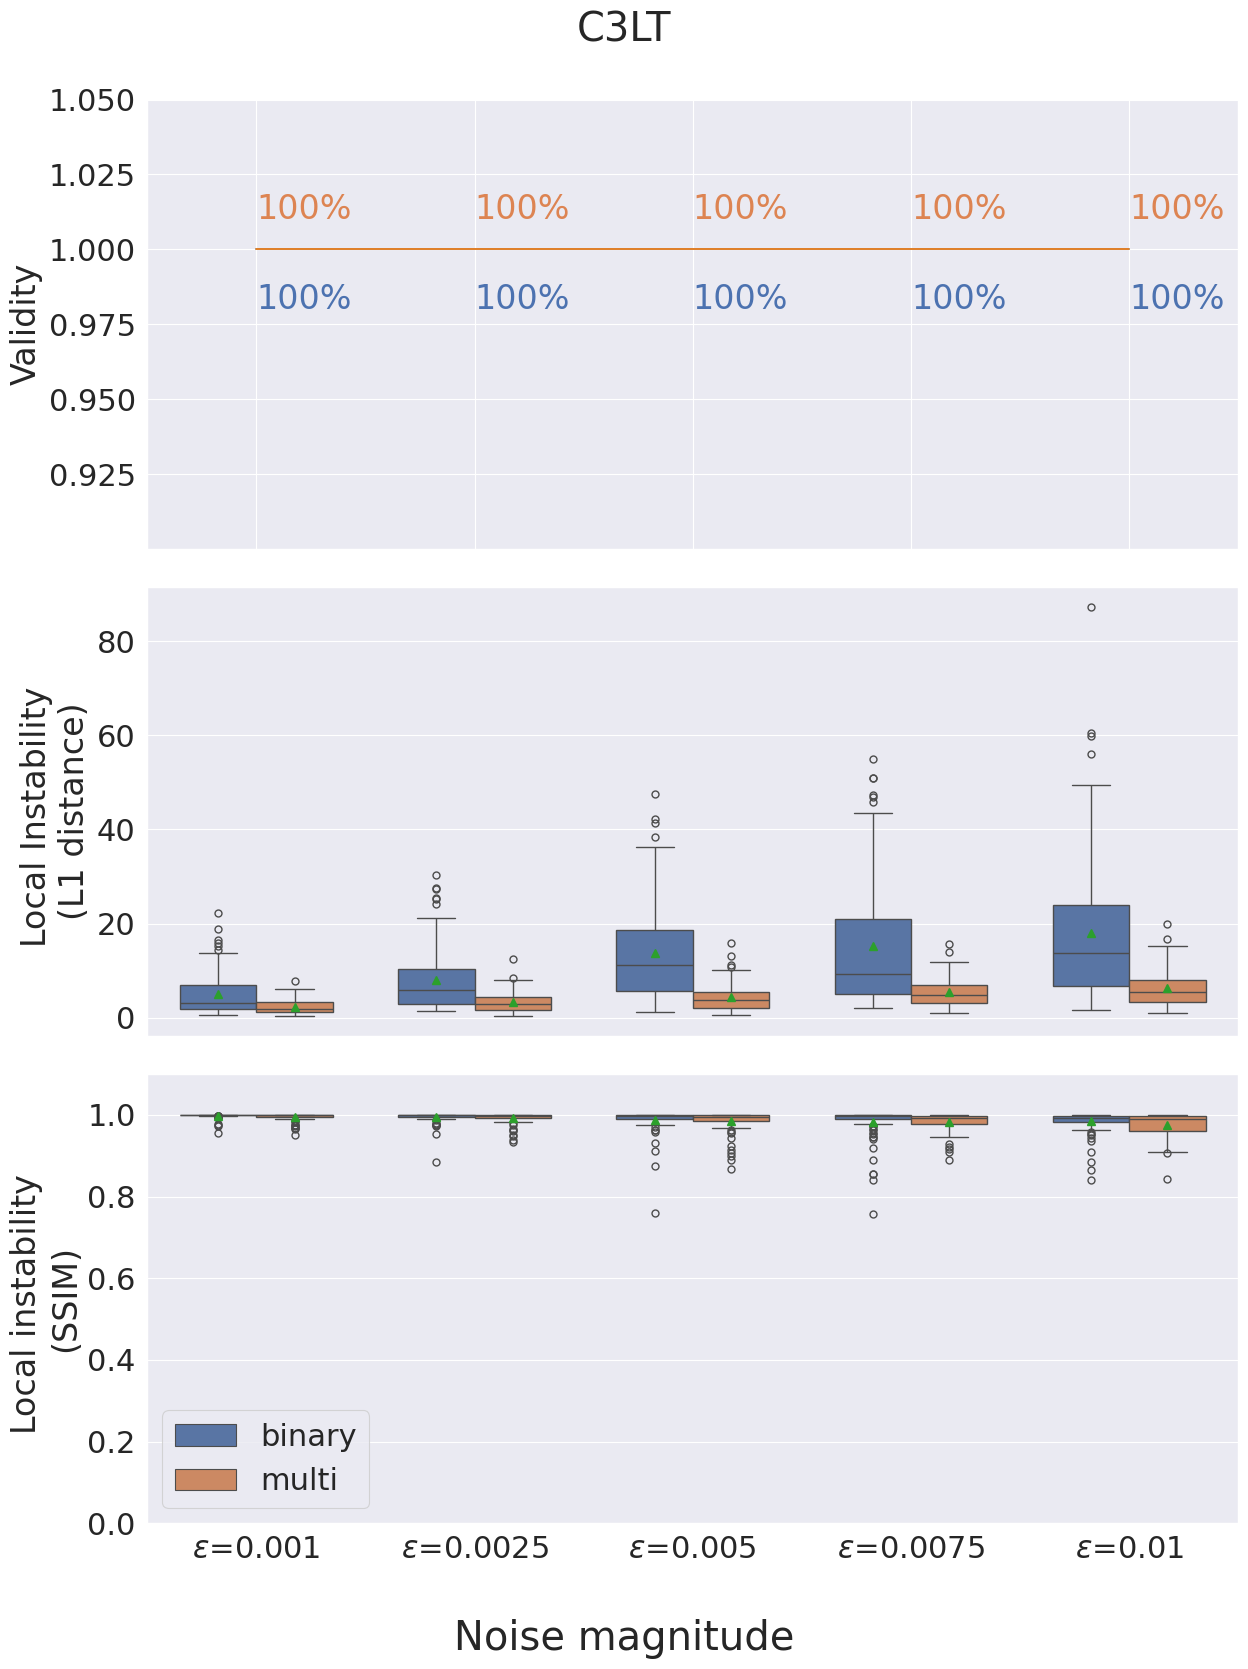

In [17]:
plotter.plot_li_results(save_path=osp.join(root_dir, f'{method}_{target_class}_li.png'), figsize=(13, 17), title=method.upper())

In [12]:
# plotter.plot_ssim_results(save_path=osp.join(root_dir, f'{method}_{target_class}_li_ssim.png'))

### Local Instability: REVISE/FashionMNIST

In [21]:
method = 'revise'
ds_name = 'fmnist'
target_class = '4'
root_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist'
# 'D:\PycharmProjects\CF-Robustness-Benchmark\cf_output\mnist'

In [25]:
parser = ResultsParser(method=method, dataset_name=ds_name, target_class=target_class, results_dir=root_dir)
li_bin = parser.parse_li_results(setting='binary')
li_multi = parser.parse_li_results(setting='multiclass')

In [38]:
plotter = Plotter(li_bin, li_multi, noise_magnitudes=noise_levels)

Saved plot to /data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/revise_4_li.png


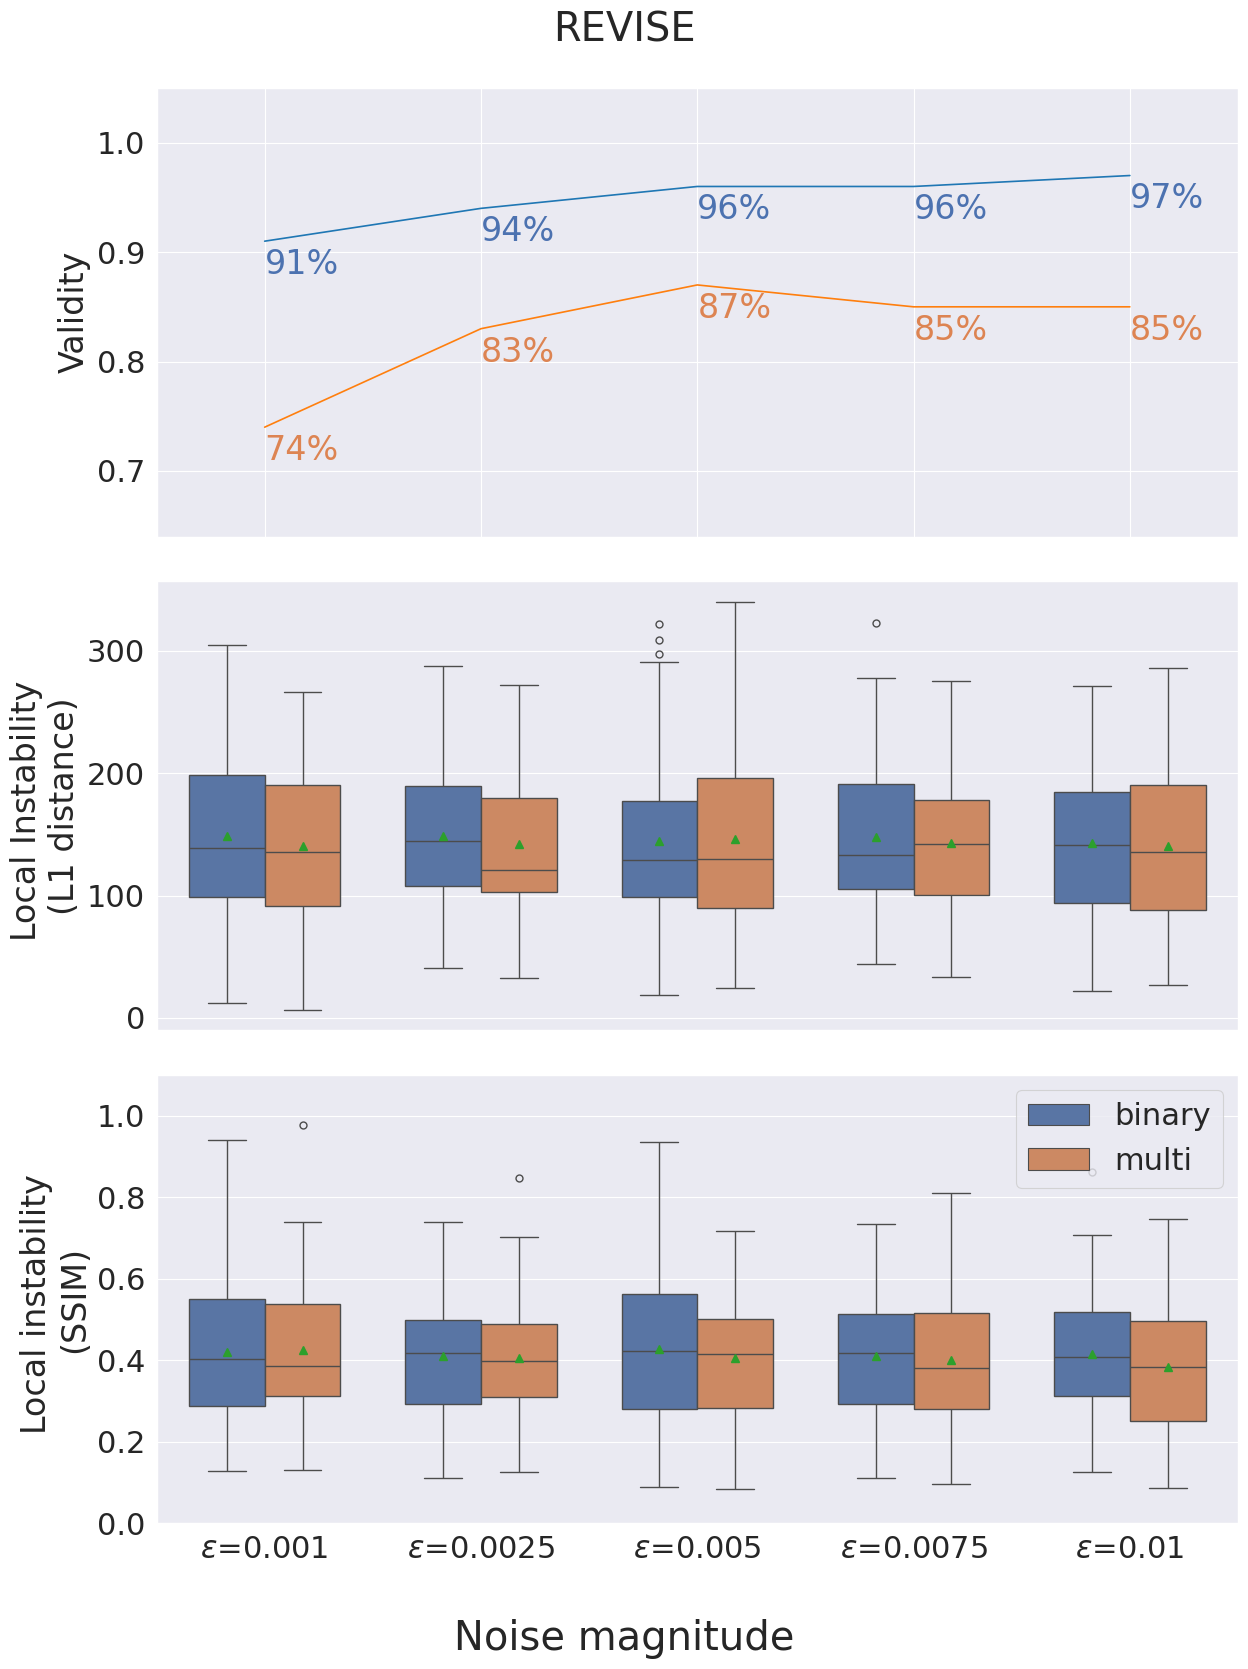

In [41]:
plotter.plot_li_results(save_path=osp.join(root_dir, f'{method}_{target_class}_li.png'), figsize=(13, 17), title=method.upper(), val_text_padding=(-0.03, -0.03))